In [31]:
#Baseline(LogReg) → 요약/Confusion Matrix → SVM baseline → LogReg Top-3 → SVM 튜닝(GridSearch

In [61]:
"""
STEP 0: Setup — import libraries
STEP 1: Load dataset (BANKING77)
STEP 2: Split features (X) and labels (y) for train/test
STEP 3: Vectorization — Word TF-IDF (1–2gram)
STEP 4: Vectorization — Char TF-IDF (char_wb 3–5gram)
STEP 5: Feature combination — hstack(Word, Char)
STEP 6: Train/Eval — Word TF-IDF + Logistic Regression
STEP 7: Train/Eval — Word+Char TF-IDF + Logistic Regression
STEP 8: Create & save summary table (m_word, m_combo)
STEP 9: Plot & save confusion matrix (Word+Char + LR)
STEP 10: LinearSVC baseline (C=1.0) on Word+Char features
STEP 11: Top-3 accuracy (LogReg only; uses predict_proba)
STEP 12: LinearSVC hyperparameter tuning (GridSearchCV: C, loss, dual) + test metrics
"""

'\nSTEP 0: Setup — import libraries\nSTEP 1: Load dataset (BANKING77)\nSTEP 2: Split features (X) and labels (y) for train/test\nSTEP 3: Vectorization — Word TF-IDF (1–2gram)\nSTEP 4: Vectorization — Char TF-IDF (char_wb 3–5gram)\nSTEP 5: Feature combination — hstack(Word, Char)\nSTEP 6: Train/Eval — Word TF-IDF + Logistic Regression\nSTEP 7: Train/Eval — Word+Char TF-IDF + Logistic Regression\nSTEP 8: Create & save summary table (m_word, m_combo)\nSTEP 9: Plot & save confusion matrix (Word+Char + LR)\nSTEP 10: LinearSVC baseline (C=1.0) on Word+Char features\nSTEP 11: Top-3 accuracy (LogReg only; uses predict_proba)\nSTEP 12: LinearSVC hyperparameter tuning (GridSearchCV: C, loss, dual) + test metrics\n'

In [44]:
print("STEP 0/ Setup: Import libraries")

from datasets import load_dataset
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    top_k_accuracy_score
)

from scipy.sparse import hstack
import matplotlib.pyplot as plt


STEP 0/ Setup: Import libraries


In [45]:
print("STEP 1/ Load dataset: BANKING77")
ds = load_dataset("PolyAI/banking77")

STEP 1/ Load dataset: BANKING77


Using the latest cached version of the dataset since PolyAI/banking77 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /Users/jessicahong/.cache/huggingface/datasets/PolyAI___banking77/default/1.1.0/17ffc2ed47c2ed928bee64127ff1dbc97204cb974c2f980becae7c864007aed9 (last modified on Thu Aug 21 22:46:11 2025).


In [46]:
label_names = ds["train"].features["label"].names

print(f" - Available splits: {list(ds.keys())}")
print(f" - Training size: {len(ds['train'])}, Test size: {len(ds['test'])}")
print(f" - Number of label classes: {len(label_names)}")

 - Available splits: ['train', 'test']
 - Training size: 10003, Test size: 3080
 - Number of label classes: 77


In [47]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10003
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3080
    })
})


In [33]:
#data split

In [48]:
print("STEP 2/ Split X and y (train/test)")

X_train, y_train = list(ds["train"]["text"]), np.array(ds["train"]["label"])
X_test,  y_test  = list(ds["test"]["text"]),  np.array(ds["test"]["label"])

print(f" - X_train size: {len(X_train)}, X_test size: {len(X_test)}")
print(f" - y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")


STEP 2/ Split X and y (train/test)
 - X_train size: 10003, X_test size: 3080
 - y_train shape: (10003,), y_test shape: (3080,)


In [49]:
# -----------------------------
print("STEP 3/ Vectorization ① Word TF-IDF (1–2gram)")

word_vec = TfidfVectorizer(
    ngram_range=(1,2),      # use word unigrams and bigrams
    min_df=2,               # ignore terms that appear in fewer than 2 documents
    max_features=100_000,   # limit vocabulary size
    lowercase=True          # convert all text to lowercase
)

Xtr_word = word_vec.fit_transform(X_train)
Xte_word = word_vec.transform(X_test)

print(f" - Xtr_word shape: {Xtr_word.shape}, Xte_word shape: {Xte_word.shape}")


STEP 3/ Vectorization ① Word TF-IDF (1–2gram)
 - Xtr_word shape: (10003, 10292), Xte_word shape: (3080, 10292)


In [50]:
# -----------------------------
print("STEP 4/ Vectorization ② Char TF-IDF (char_wb 3–5gram)")

char_vec = TfidfVectorizer(
    analyzer="char_wb",     # extract character n-grams inside word boundaries
    ngram_range=(3,5),      # use character 3-grams to 5-grams
    min_df=2,               # ignore n-grams that appear in fewer than 2 documents
    max_features=150_000,   # limit feature space size
    lowercase=True          # convert all text to lowercase
)

Xtr_char = char_vec.fit_transform(X_train)
Xte_char = char_vec.transform(X_test)

print(f" - Xtr_char shape: {Xtr_char.shape}, Xte_char shape: {Xte_char.shape}")


STEP 4/ Vectorization ② Char TF-IDF (char_wb 3–5gram)
 - Xtr_char shape: (10003, 13498), Xte_char shape: (3080, 13498)


In [51]:
# -----------------------------
print("STEP 5/ Feature combination (Word + Char) → hstack")

Xtr_combo = hstack([Xtr_word, Xtr_char])
Xte_combo = hstack([Xte_word, Xte_char])

print(f" - Xtr_combo shape: {Xtr_combo.shape}, Xte_combo shape: {Xte_combo.shape}")


STEP 5/ Feature combination (Word + Char) → hstack
 - Xtr_combo shape: (10003, 23790), Xte_combo shape: (3080, 23790)


In [52]:
## 3) Simple training/evaluation function (Logistic Regression only)
def train_eval(Xtr, Xte, y_train, y_test, name="model"):
    # Define Logistic Regression classifier
    clf = LogisticRegression(
        solver="saga",             # efficient for large, sparse datasets
        multi_class="multinomial", # softmax-style multi-class classification
        max_iter=2000,             # high iteration cap for convergence
        n_jobs=-1,                 # utilize all CPU cores
        random_state=42            # ensure reproducibility
    )
    
    # Train the classifier
    clf.fit(Xtr, y_train)
    
    # Predict on the test set
    pred = clf.predict(Xte)

    # Collect evaluation metrics
    metrics = {
        "model": name,
        "accuracy": accuracy_score(y_test, pred),
        "f1_macro": f1_score(y_test, pred, average="macro"),
        "f1_weighted": f1_score(y_test, pred, average="weighted"),
        "precision_macro": precision_score(y_test, pred, average="macro"),
        "recall_macro": recall_score(y_test, pred, average="macro"),
    }

    # Print main results
    print(f"\n[{name}]")
    print(f"Accuracy: {metrics['accuracy']:.4f} | Macro-F1: {metrics['f1_macro']:.4f}")
    
    return clf, pred, metrics

In [53]:
# Train & evaluate Word-level TF-IDF baseline
clf_word, pred_word, m_word = train_eval(
    Xtr_word, Xte_word, y_train, y_test, "Word TF-IDF"
)

# Train & evaluate Word+Char-level TF-IDF baseline
clf_combo, pred_combo, m_combo = train_eval(
    Xtr_combo, Xte_combo, y_train, y_test, "Word+Char TF-IDF"
)


[Word TF-IDF]
Accuracy: 0.8578 | Macro-F1: 0.8568

[Word+Char TF-IDF]
Accuracy: 0.8997 | Macro-F1: 0.8997


In [54]:
print("\nSTEP 8/ Create and save summary table")

summary_df = pd.DataFrame([m_word, m_combo])
cols = ["model", "accuracy", "f1_macro", "f1_weighted", "precision_macro", "recall_macro"]
summary_df = summary_df[cols]

# Print results in a clean table format
print(summary_df.to_string(index=False))

# Save summary to CSV
summary_df.to_csv("intent_baselines_summary.csv", index=False)
print(" - Saved: intent_baselines_summary.csv")



STEP 8/ Create and save summary table
           model  accuracy  f1_macro  f1_weighted  precision_macro  recall_macro
     Word TF-IDF  0.857792  0.856808     0.856808         0.867049      0.857792
Word+Char TF-IDF  0.899675  0.899682     0.899682         0.904590      0.899675
 - Saved: intent_baselines_summary.csv



STEP 9/ Plot and save confusion matrix (Word+Char baseline)


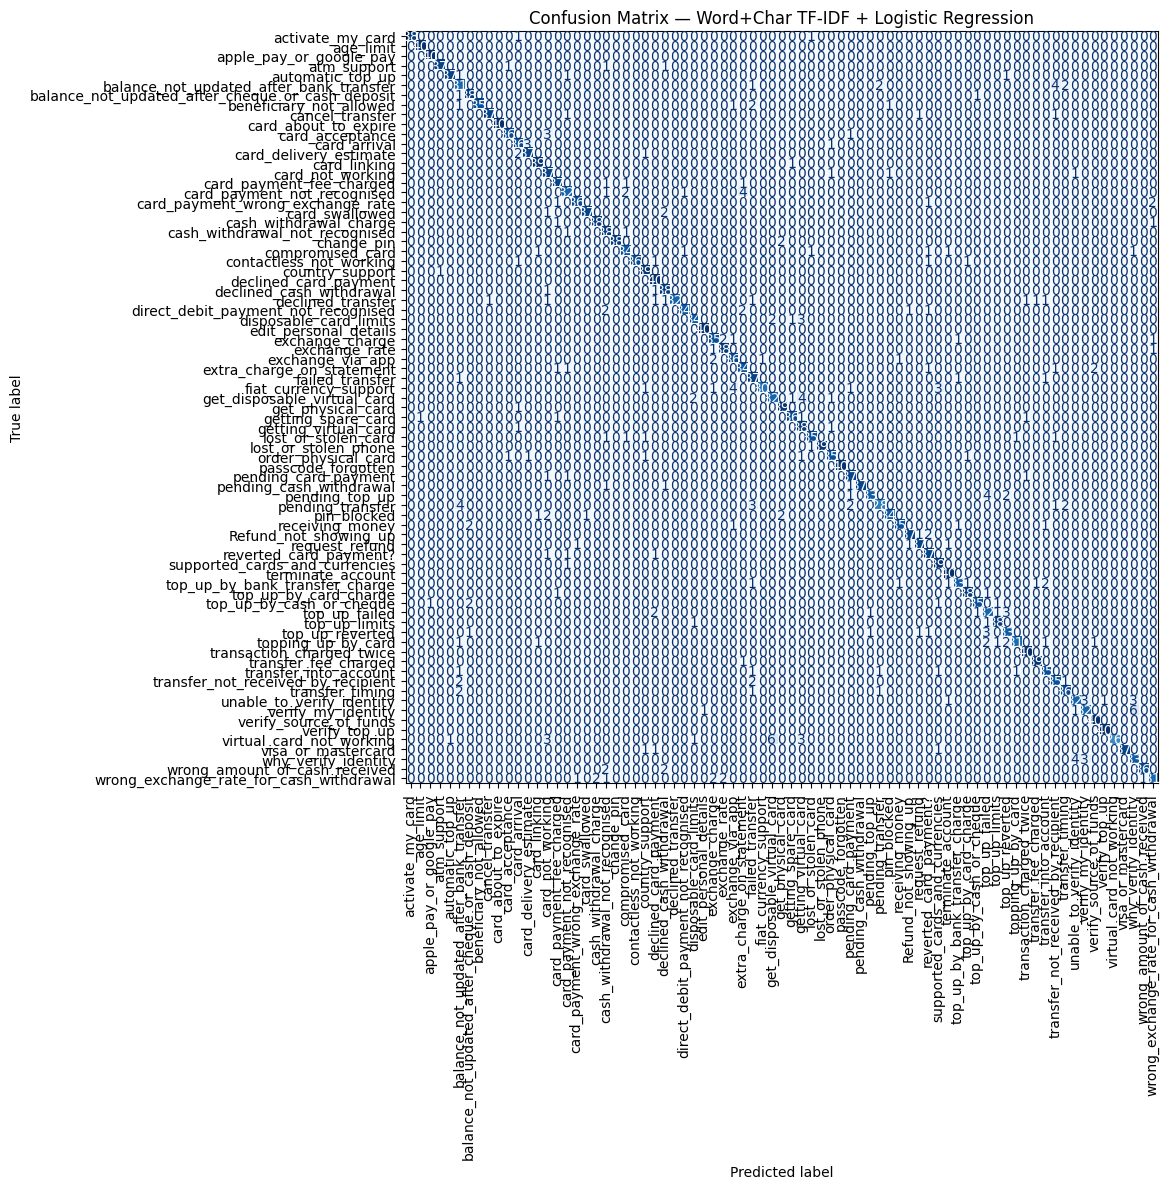

 - Saved: confusion_matrix_combo.png


In [55]:
#STEP 9: Confusion Matrix# -----------------------------
print("\nSTEP 9/ Plot and save confusion matrix (Word+Char baseline)")

# Compute confusion matrix using the Word+Char TF-IDF baseline predictions
cm = confusion_matrix(y_test, pred_combo)

# Build display with human-readable label names if available
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

# Plot and save
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, xticks_rotation=90, cmap="Blues", values_format="d", colorbar=False)
plt.title("Confusion Matrix — Word+Char TF-IDF + Logistic Regression")
plt.tight_layout()
plt.savefig("confusion_matrix_combo.png", dpi=200)
plt.show()

print(" - Saved: confusion_matrix_combo.png")


In [57]:
# -----------------------------
# STEP 10: LinearSVC baseline (C=1.0)

from sklearn.svm import LinearSVC

# Train baseline LinearSVC on Word+Char TF-IDF features
svm = LinearSVC(C=1.0, random_state=42)
svm.fit(Xtr_combo, y_train)

# Predict on the test set
pred = svm.predict(Xte_combo)

# Evaluate baseline SVM performance
print("SVM Accuracy:", accuracy_score(y_test, pred))
print("SVM Macro-F1:", f1_score(y_test, pred, average="macro"))


SVM Accuracy: 0.9084415584415585
SVM Macro-F1: 0.9085257307903346


In [58]:
# -----------------------------
# STEP 11: Evaluate Top-3 accuracy (Logistic Regression only)

from sklearn.metrics import top_k_accuracy_score

# Logistic Regression supports predict_proba (unlike LinearSVC),
# so we can calculate Top-k accuracy. This is useful in intent
# classification where multiple candidate intents are considered.
print("Top-3 Accuracy (LogReg):", 
      top_k_accuracy_score(y_test, clf_combo.predict_proba(Xte_combo), k=3))


Top-3 Accuracy (LogReg): 0.9681818181818181


In [59]:
# -----------------------------
# STEP 12: LinearSVC hyperparameter tuning (GridSearchCV)

from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

# Define the search space
param_grid = {
    "C": [0.5, 1.0, 2.0],
    "loss": ["hinge", "squared_hinge"],
    "dual": [True, False],
}

# Grid search with 3-fold cross-validation, optimizing for macro-F1
grid = GridSearchCV(
    estimator=LinearSVC(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1,
)

# Fit on the combined Word+Char TF-IDF features
grid.fit(Xtr_combo, y_train)

# Evaluate the best model on the test set
best_svc = grid.best_estimator_
pred_best = best_svc.predict(Xte_combo)

print("Best params:", grid.best_params_)
print("Best Accuracy:", accuracy_score(y_test, pred_best))
print("Best Macro-F1:", f1_score(y_test, pred_best, average="macro"))



Fitting 3 folds for each of 12 candidates, totalling 36 fits


/Users/jessicahong/.pyenv/versions/3.10.12/envs/nlp_env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
9 fits failed out of a total of 36.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jessicahong/.pyenv/versions/3.10.12/envs/nlp_env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jessicahong/.pyenv/versions/3.10.12/envs/nlp_env/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/Users/jessicahong/.pyenv

Best params: {'C': 1.0, 'dual': True, 'loss': 'squared_hinge'}
Best Accuracy: 0.9084415584415585
Best Macro-F1: 0.9085257307903346
